In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import silhouette_samples
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.preprocessing import StandardScaler
from pyclustertend import hopkins
from sklearn.manifold import TSNE
from sklearn.metrics import homogeneity_score, completeness_score, v_measure_score
from scipy.spatial.distance import pdist, squareform
from skfuzzy.cluster import cmeans
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage, dendrogram, cophenet
from sklearn.decomposition import PCA

In [21]:
nba = pd.read_csv('nba_players.csv')
cbb = pd.read_csv('college_players.csv')

In [22]:
nba_names = nba['name'].to_list()

In [23]:
def f(x):
    if x in nba_names:
        return 1
    return 0

def h(x):
    if x not in ['Guard', 'Forward', 'Center']:
        return 'Unknown'
    return x

def g(x):
    if x == 'Unknown':
        return 0
    x = x.split('-')
    return 12*int(x[0]) + int(x[1])

def i(x):
    return int(x)

In [24]:
cbb['nba'] = cbb['name'].apply(f)
cbb['position'] = cbb['position'].fillna('Unknown')
cbb['position'] = cbb['position'].apply(h)
cbb['height'] = cbb['height'].apply(g)

cbb = cbb.drop(cbb[cbb['weight'] == 'Unknown'].index, axis=0)
cbb = cbb.drop(cbb[cbb['position'] == 'Unknown'].index, axis=0)
cbb = cbb.drop(['Unnamed: 0', 'name'], axis=1)

cbb['weight'] = cbb['weight'].apply(i)

In [25]:
cbb.head()

height  weight position  games_played  min_per  field_goal  field_attmps  \
0      76     175    Guard           144        0         3.2           7.3   
1      76     195    Guard           139        0         1.8           4.0   
3      80     221  Forward           118        0         2.0           5.3   
4      78     200  Forward           120        0         3.5           7.3   
5      74     185    Guard           138        0         2.9           7.5   

   two_pointer  two_pct  three_ptrs  ...  personal_fouls   usg  off_reb  \
0          2.1    0.499         1.1  ...             1.7  17.5      2.6   
1          1.2    0.486         0.6  ...             1.0  15.3      2.9   
3          0.9    0.440         1.1  ...             1.4  20.5      3.5   
4          2.6    0.517         0.8  ...             2.6   0.0      0.0   
5          2.0    0.425         0.9  ...             2.2  21.4      2.5   

   def_reb  total_reb  player_eff  tv_per_game      ws  bpm  nba  
0      9.8        2.8      14.800          9.5  13.200  4.7    0  
1      7.0        1.5      12.400         14.2   7.300  4.1    0  
3     11.7        2.3      11.000         11.1   3.100 -1.0    0  
4      8.2        4.0       0.592         18.2   0.144  0.0    0  
5     12.3        3.1      13.700         17.3   8.300  2.8    0  

[5 rows x 27 columns]

In [26]:
nba = cbb[cbb.nba == 1]
not_nba = cbb[cbb.nba == 0]

In [27]:
nba.describe()

height      weight  games_played  min_per  field_goal  \
count  200.000000  200.000000     200.00000    200.0  200.000000   
mean    78.960000  218.275000      87.33500      0.0    4.065000   
std      3.279049   25.264617      38.11333      0.0    1.262953   
min     69.000000  155.000000      14.00000      0.0    0.700000   
25%     77.000000  200.000000      55.75000      0.0    3.300000   
50%     79.000000  215.000000      94.50000      0.0    4.000000   
75%     82.000000  237.250000     122.00000      0.0    4.900000   
max     85.000000  275.000000     152.00000      0.0    7.600000   

       field_attmps  two_pointer     two_pct  three_ptrs   three_pct  ...  \
count    200.000000   200.000000  200.000000  200.000000  200.000000  ...   
mean       8.495000     3.162000    0.523490    0.901500    0.300490  ...   
std        2.814013     1.238031    0.056914    0.763783    0.139844  ...   
min        1.500000     0.300000    0.374000    0.000000    0.000000  ...   
25%        6.600000     2.300000    0.484000    0.175000    0.271750  ...   
50%        8.400000     3.000000    0.521500    0.800000    0.343500  ...   
75%       10.300000     3.900000    0.565000    1.500000    0.377250  ...   
max       17.200000     7.000000    0.746000    3.100000    1.000000  ...   

       personal_fouls         usg     off_reb     def_reb   total_reb  \
count      200.000000  200.000000  200.000000  200.000000  200.000000   
mean         2.111000   17.219500    6.335000   14.675500    4.998500   
std          0.481809    9.919017    5.431582    5.790796    1.961091   
min          0.600000    0.000000    0.000000    0.000000    1.300000   
25%          1.800000   15.525000    1.800000   10.375000    3.400000   
50%          2.100000   20.900000    5.000000   14.100000    4.800000   
75%          2.425000   23.825000   10.325000   18.425000    6.025000   
max          3.400000   32.200000   25.400000   31.200000   10.400000   

       player_eff  tv_per_game          ws          bpm    nba  
count  200.000000   200.000000  200.000000   200.000000  200.0  
mean    15.992740    16.127000    7.190300    25.447500    1.0  
std      9.338155     5.688591    5.797292   168.813199    0.0  
min      0.511000     0.000000    0.114000    -0.200000    1.0  
25%     13.025000    12.175000    1.450000     2.375000    1.0  
50%     18.650000    15.300000    6.400000     6.400000    1.0  
75%     22.600000    18.625000   11.350000     8.400000    1.0  
max     35.100000    34.600000   22.200000  1685.000000    1.0  

[8 rows x 26 columns]

In [28]:
not_nba.describe()

height       weight  games_played  min_per   field_goal  \
count  1508.000000  1508.000000   1508.000000   1508.0  1508.000000   
mean     77.070292   208.666446     74.312997      0.0     1.793103   
std       5.685203    26.201091     45.903206      0.0     1.478855   
min       0.000000   145.000000      1.000000      0.0     0.000000   
25%      75.000000   190.000000     30.750000      0.0     0.400000   
50%      77.000000   205.000000     76.000000      0.0     1.600000   
75%      80.000000   225.000000    118.000000      0.0     2.800000   
max      88.000000   314.000000    179.000000      0.0     6.600000   

       field_attmps  two_pointer      two_pct   three_ptrs    three_pct  ...  \
count   1508.000000  1508.000000  1508.000000  1508.000000  1508.000000  ...   
mean       4.118568     1.299403     0.438278     0.493037     0.238973  ...   
std        3.306299     1.178172     0.180301     0.598925     0.178698  ...   
min        0.000000     0.000000     0.000000     0.000000     0.000000  ...   
25%        1.000000     0.300000     0.409000     0.000000     0.000000  ...   
50%        3.500000     1.100000     0.471000     0.200000     0.297000  ...   
75%        6.400000     2.000000     0.525000     0.800000     0.354000  ...   
max       14.500000     6.600000     1.000000     3.000000     1.000000  ...   

       personal_fouls          usg      off_reb      def_reb    total_reb  \
count     1508.000000  1508.000000  1508.000000  1508.000000  1508.000000   
mean         1.348077    13.524271     4.713064    12.039920     2.384947   
std          0.823028     9.762200     5.992126     6.982473     1.812760   
min          0.000000     0.000000     0.000000     0.000000     0.000000   
25%          0.600000     0.000000     0.000000     8.200000     0.800000   
50%          1.500000    16.000000     3.100000    11.500000     2.200000   
75%          2.000000    20.600000     7.700000    15.300000     3.425000   
max          3.500000    57.000000   100.000000   100.000000    11.700000   

        player_eff  tv_per_game           ws          bpm     nba  
count  1508.000000  1508.000000  1508.000000  1508.000000  1508.0  
mean      8.740736    17.219496     3.163792    26.534019     0.0  
std       9.340796     9.584619     4.242254   164.268700     0.0  
min     -46.700000     0.000000    -0.784000   -57.000000     0.0  
25%       0.534750    12.800000     0.076000    -0.600000     0.0  
50%      10.200000    16.400000     0.600000     0.200000     0.0  
75%      15.300000    20.600000     5.700000     3.725000     0.0  
max      53.700000   100.000000    21.000000  2088.000000     0.0  

[8 rows x 26 columns]

In [32]:
cols_to_drop = ['height', 'weight', 'min_per', 'position', 'games_played', 'two_pointer', 'three_ptrs', 'free_throws', 'personal_fouls', 'assists', 'steals', 'blocks', 'off_reb', 'def_reb', 'tv_per_game', 'bpm']

cbb_copy = cbb.copy()
cbb_copy = cbb_copy.drop(cols_to_drop, axis=1)

In [33]:
cbb_copy.head()

field_goal  field_attmps  two_pct  three_pct  free_pct  points   usg  \
0         3.2           7.3    0.499      0.366     0.754     9.1  17.5   
1         1.8           4.0    0.486      0.401     0.754     5.5  15.3   
3         2.0           5.3    0.440      0.338     0.620     6.1  20.5   
4         3.5           7.3    0.517      0.370     0.829    10.6   0.0   
5         2.9           7.5    0.425      0.313     0.737     8.6  21.4   

   total_reb  player_eff      ws  nba  
0        2.8      14.800  13.200    0  
1        1.5      12.400   7.300    0  
3        2.3      11.000   3.100    0  
4        4.0       0.592   0.144    0  
5        3.1      13.700   8.300    0

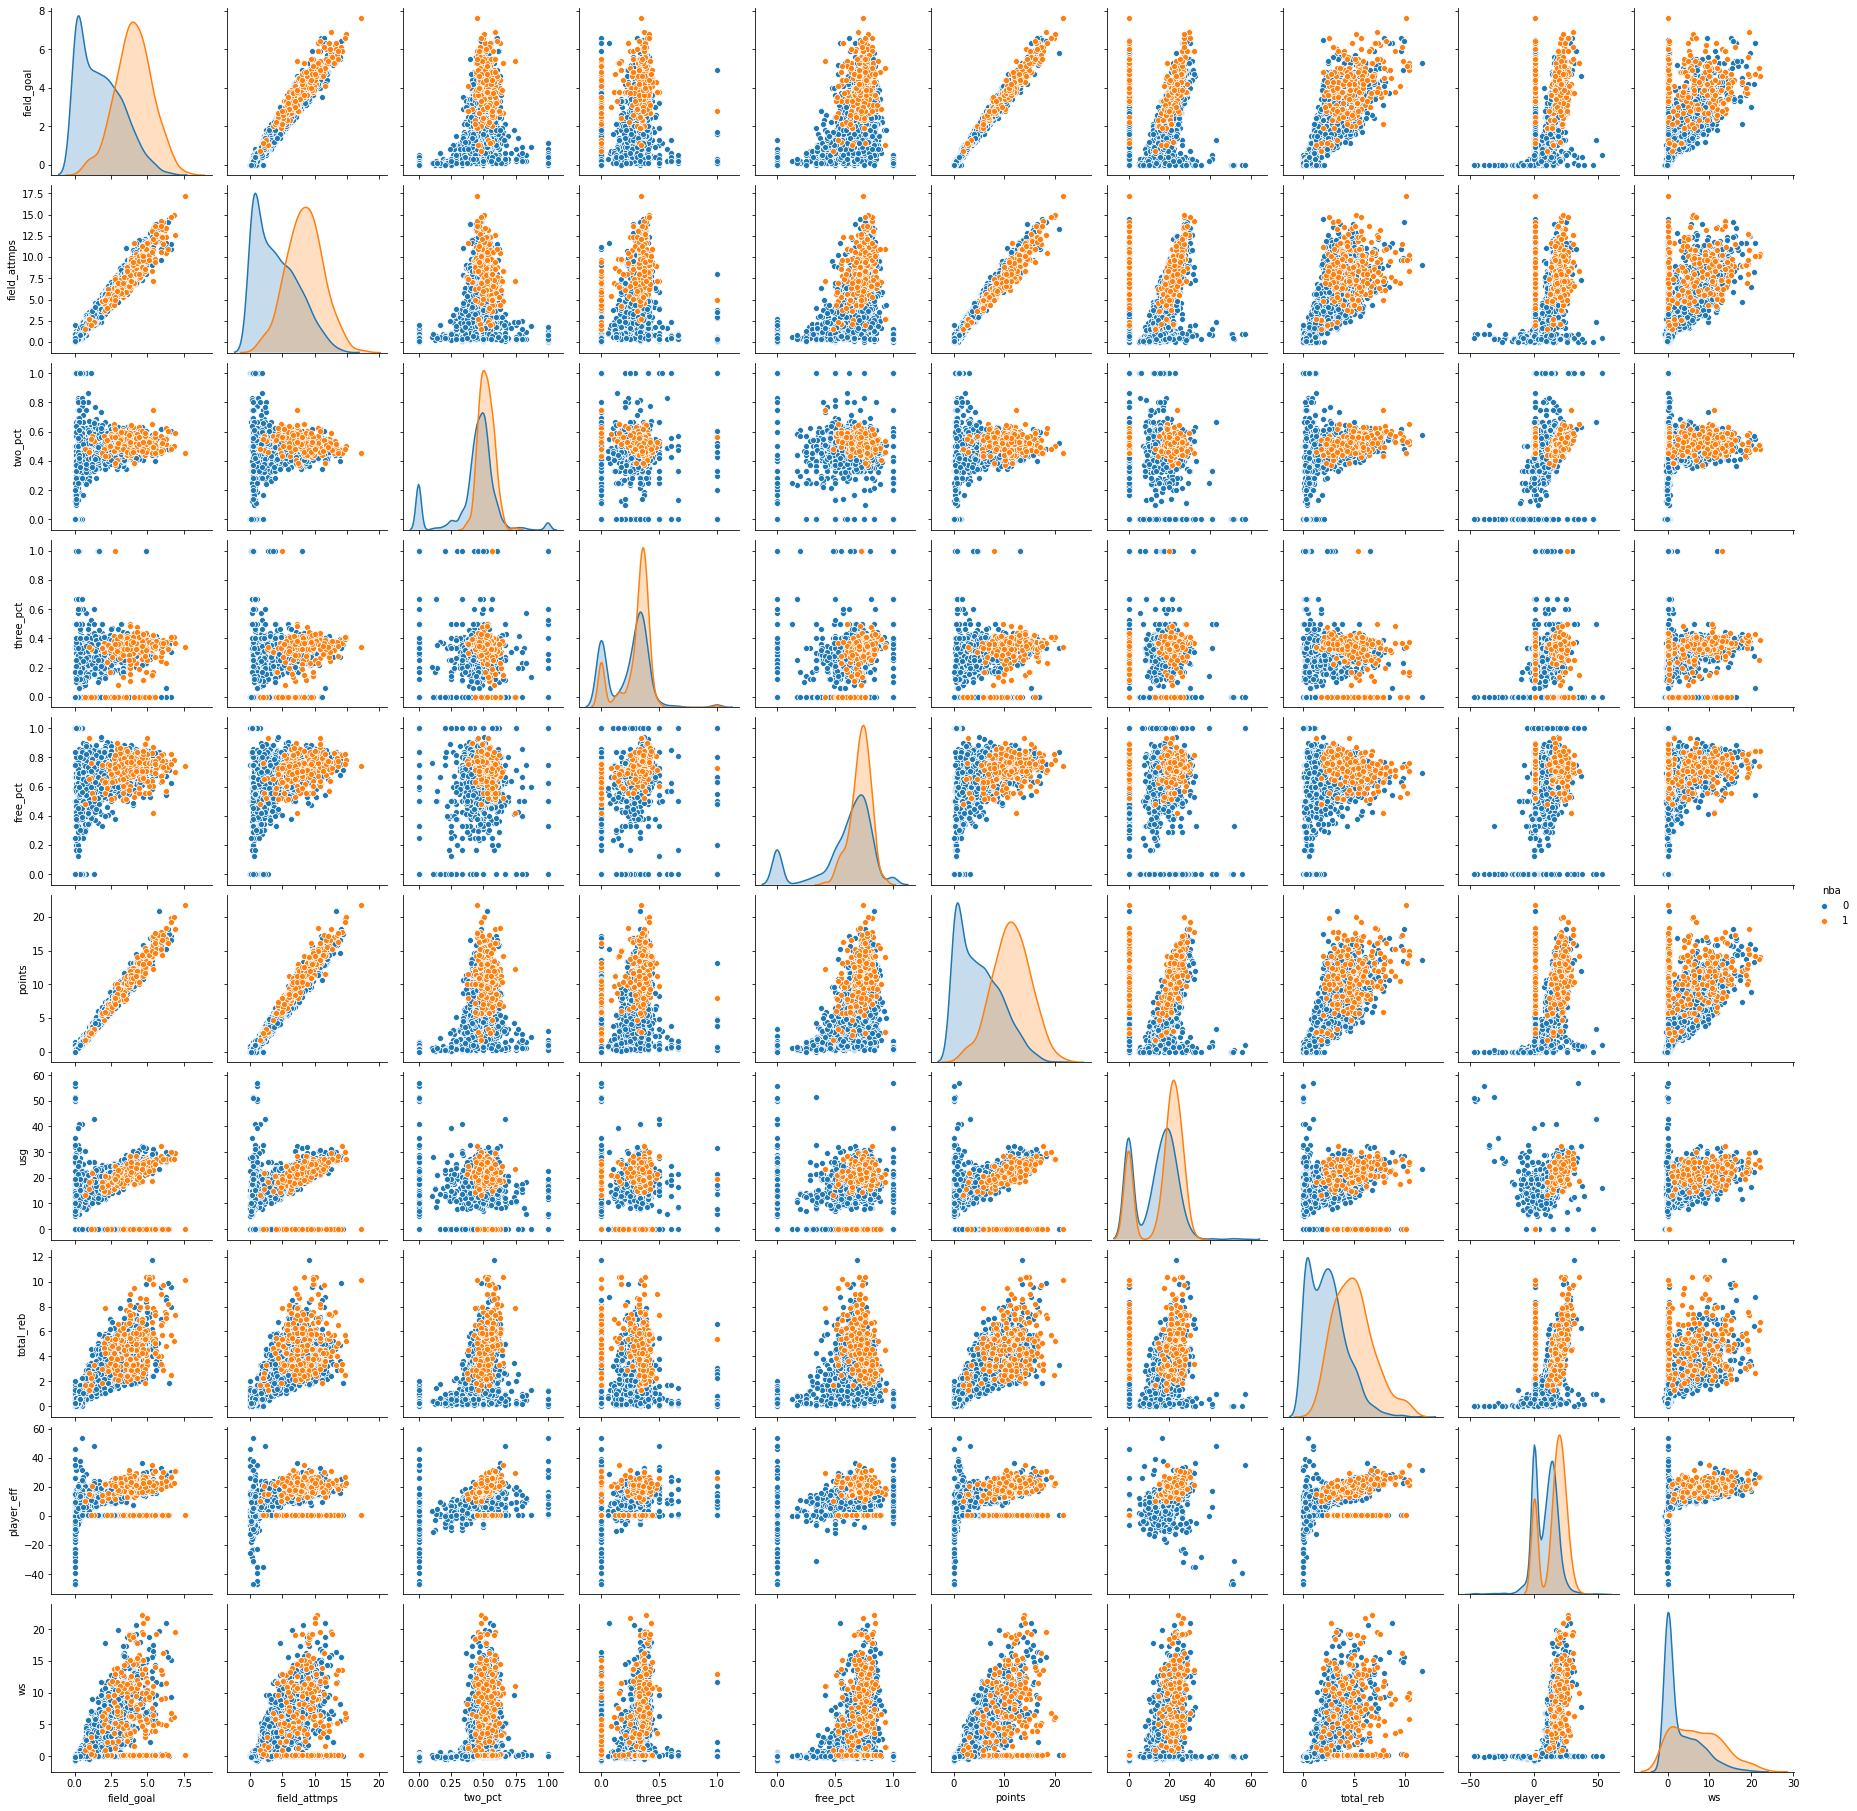

In [34]:
sns.pairplot(cbb_copy, hue='nba')
plt.show()

In [35]:
n=len(cbb_copy)
num_trials=5
hopkins_stats=[]
for i in range(0,num_trials):
    n = len(cbb_copy)
    p = int(0.1 * n)
    hopkins_stats.append(hopkins(cbb_copy,p))
print(hopkins_stats)

[0.07295827701076271, 0.07672200540245949, 0.0729333786151393, 0.07095373067727187, 0.06898668874715334]


In [52]:
df = cbb_copy.copy()
df = df.drop(['nba'], axis=1)

In [53]:
X = StandardScaler(with_std=False).fit_transform(df)

df = pd.DataFrame(X, columns = df.columns)
sub_cols = df.columns.to_list()

In [54]:
df.head()

field_goal  field_attmps   two_pct  three_pct  free_pct    points  \
0    1.140867       2.66897  0.050744   0.119823  0.149269  3.309309   
1   -0.259133      -0.63103  0.037744   0.154823  0.149269 -0.290691   
2   -0.059133       0.66897 -0.008256   0.091823  0.015269  0.309309   
3    1.440867       2.66897  0.068744   0.123823  0.224269  4.809309   
4    0.840867       2.86897 -0.023256   0.066823  0.132269  2.809309   

         usg  total_reb  player_eff       ws  
0   3.543033   0.109016    5.210083  9.56472  
1   1.343033  -1.190984    2.810083  3.66472  
2   6.543033  -0.390984    1.410083 -0.53528  
3 -13.956967   1.309016   -8.997917 -3.49128  
4   7.443033   0.409016    4.110083  4.66472

/Users/milesmathews70/opt/anaconda3/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/Users/milesmathews70/opt/anaconda3/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


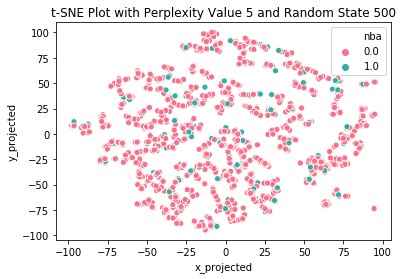

/Users/milesmathews70/opt/anaconda3/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/Users/milesmathews70/opt/anaconda3/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


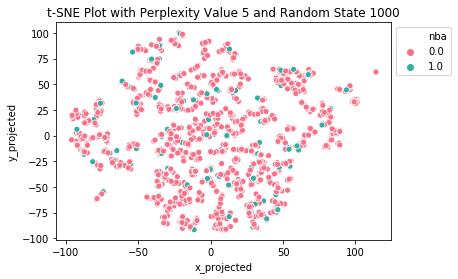

--------------------------------------------


/Users/milesmathews70/opt/anaconda3/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/Users/milesmathews70/opt/anaconda3/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


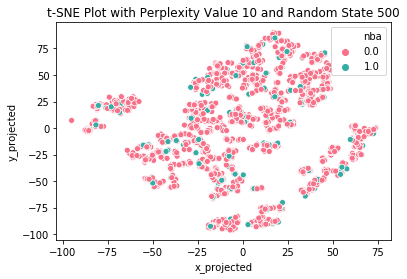

/Users/milesmathews70/opt/anaconda3/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/Users/milesmathews70/opt/anaconda3/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


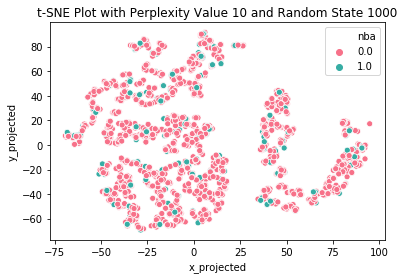

--------------------------------------------


/Users/milesmathews70/opt/anaconda3/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/Users/milesmathews70/opt/anaconda3/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


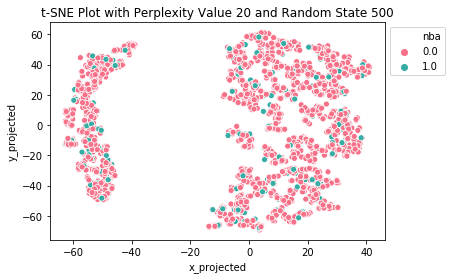

/Users/milesmathews70/opt/anaconda3/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/Users/milesmathews70/opt/anaconda3/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


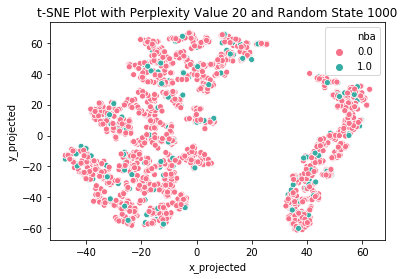

--------------------------------------------


/Users/milesmathews70/opt/anaconda3/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/Users/milesmathews70/opt/anaconda3/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


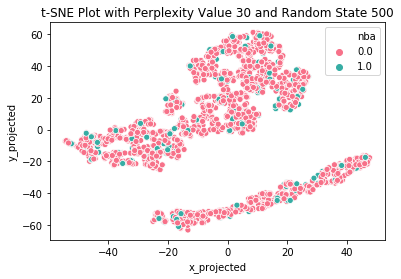

/Users/milesmathews70/opt/anaconda3/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/Users/milesmathews70/opt/anaconda3/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


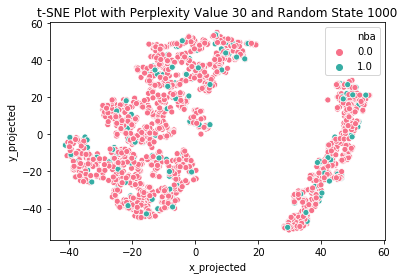

--------------------------------------------


/Users/milesmathews70/opt/anaconda3/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/Users/milesmathews70/opt/anaconda3/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


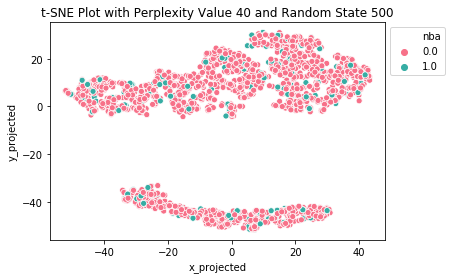

/Users/milesmathews70/opt/anaconda3/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/Users/milesmathews70/opt/anaconda3/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


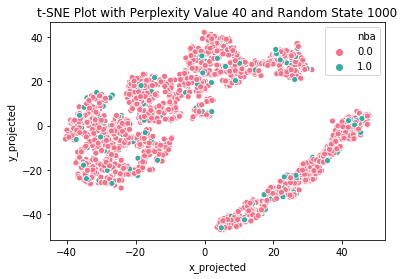

--------------------------------------------


/Users/milesmathews70/opt/anaconda3/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/Users/milesmathews70/opt/anaconda3/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


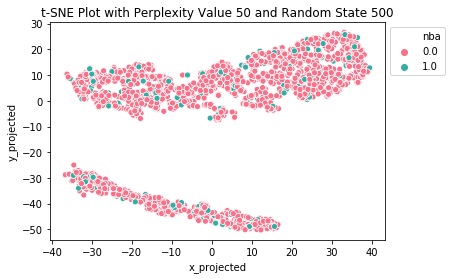

/Users/milesmathews70/opt/anaconda3/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/Users/milesmathews70/opt/anaconda3/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


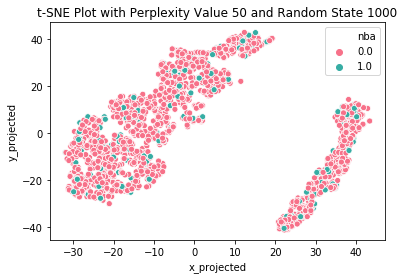

--------------------------------------------


In [41]:
for perp in [5,10, 20, 30, 40, 50]: 
    for rs in [500, 1000]:
        tsne = TSNE(n_components=2, perplexity=perp, random_state=rs)
        data_tsne = tsne.fit_transform(X)
        df_tsne = pd.DataFrame(data_tsne, columns=['x_projected', 'y_projected'])
        df_combo = pd.concat([df, df_tsne], axis=1)
        df_combo['nba'] = cbb['nba']
        sns.scatterplot(x='x_projected',y='y_projected', hue='nba', palette=sns.color_palette("husl", 2), data=df_combo)
        plt.title('t-SNE Plot with Perplexity Value %s and Random State %s' %(perp, rs))
        plt.legend(bbox_to_anchor=(1,1))
        plt.show()
    print('--------------------------------------------')

/Users/milesmathews70/opt/anaconda3/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/Users/milesmathews70/opt/anaconda3/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


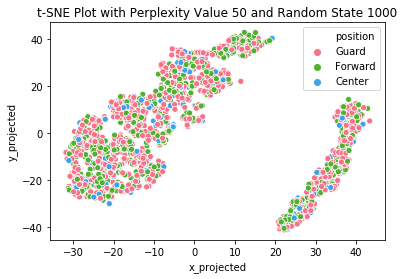

In [48]:
perp = 50
rs = 1000

tsne = TSNE(n_components=2, perplexity=perp, random_state=rs)
data_tsne = tsne.fit_transform(X)
df_tsne = pd.DataFrame(data_tsne, columns=['x_projected', 'y_projected'])
df_combo = pd.concat([df, df_tsne], axis=1)
df_combo['position'] = cbb['position']
sns.scatterplot(x='x_projected',y='y_projected', hue='position', palette=sns.color_palette("husl", 3), data=df_combo)
plt.title('t-SNE Plot with Perplexity Value %s and Random State %s' %(perp, rs))
plt.legend(bbox_to_anchor=(1,1))
plt.show()

k= 1
k= 2
k= 3
k= 4
k= 5
k= 6
k= 7
k= 8
k= 9
k= 10
k= 11


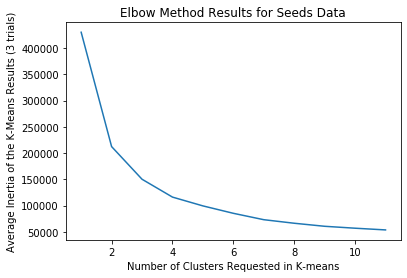

In [55]:
cluster_num_list=range(1,12)
avg_inertia_list=[]
for k in cluster_num_list:
    print('k= '+str(k))
    sub_inertia_list=[]
    for i in range(0,3):
        kmeans=KMeans(n_clusters=k).fit(X)
        sub_inertia_list.append(kmeans.inertia_)
    avg_inertia_list.append(np.average(sub_inertia_list))
    
plt.plot(cluster_num_list,avg_inertia_list)
plt.xlabel('Number of Clusters Requested in K-means')
plt.ylabel('Average Inertia of the K-Means Results (3 trials)')
plt.title('Elbow Method Results for Seeds Data')
plt.show()

In [56]:
kmeans=KMeans(n_clusters=4).fit(X)
df['predicted_cluster_kmeans']=kmeans.labels_

/Users/milesmathews70/opt/anaconda3/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/Users/milesmathews70/opt/anaconda3/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


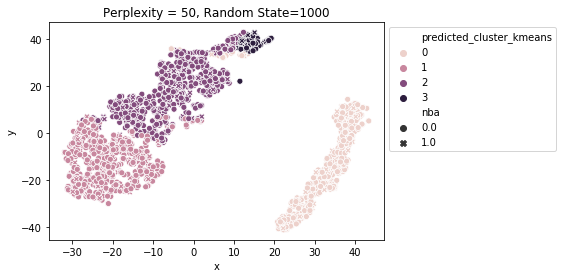

In [57]:
# Perform the TSNE non-linear dimensionality reduction
tsne = TSNE(n_components=2, perplexity=perp, random_state=rs)
data_tsne = tsne.fit_transform(X)
#concatenate the projected (x,y) coordinates (df_tsne) and the original dataset (df) into the sam
df_tsne = pd.DataFrame(data_tsne, columns=['x', 'y'], index=df.index)
dff = pd.concat([df, df_tsne], axis=1)
dff['nba'] = cbb['nba']
# Plot the projected (x,y) coordinates
sns.scatterplot(x='x', y='y', hue='predicted_cluster_kmeans', style='nba', data=dff)
plt.title('Perplexity = 50, Random State=1000')
plt.legend(bbox_to_anchor=(1,1))
plt.show()

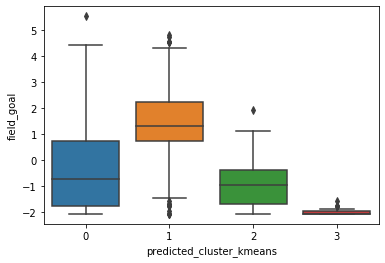

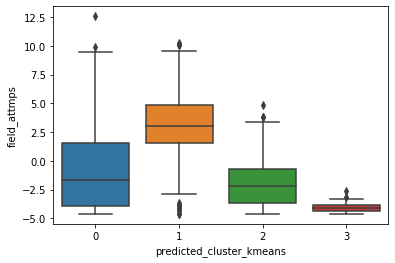

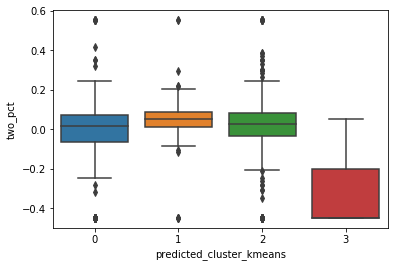

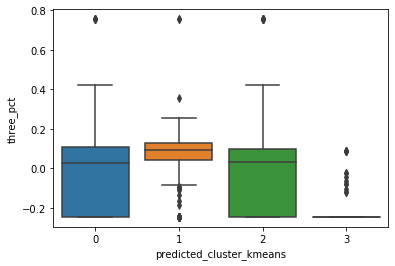

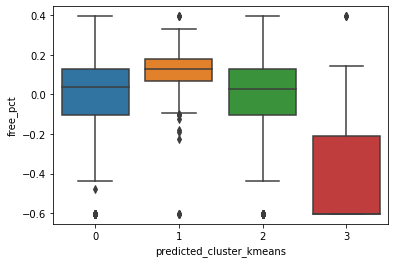

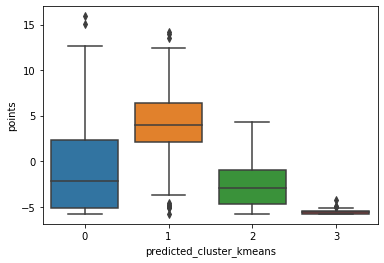

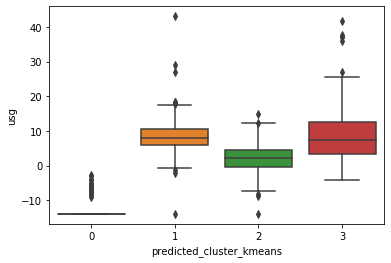

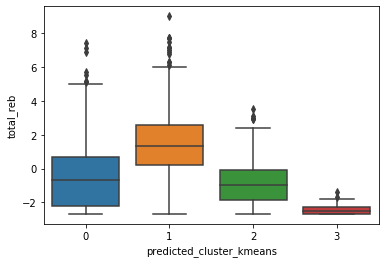

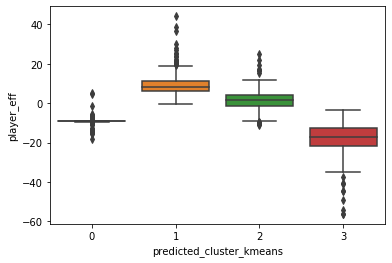

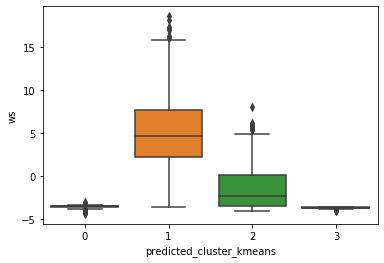

In [58]:
for col in sub_cols:
    sns.boxplot(x='predicted_cluster_kmeans', y=col, data=df)
    plt.show()

(array([1., 0., 0., 0., 0., 0., 0., 0., 1., 2.]),
 array([0.06 , 0.087, 0.114, 0.141, 0.168, 0.195, 0.222, 0.249, 0.276,
        0.303, 0.33 ]),
 <a list of 10 Patch objects>)

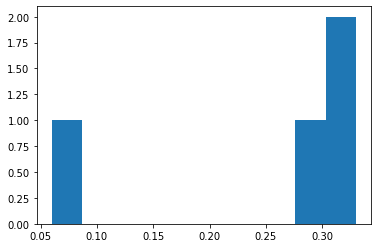

In [72]:
nbas = []
n = len(cbb_copy[cbb_copy['nba'] == 1])
df['nba'] = cbb_copy['nba']
for i in range(4):
    nbas.append(len(df[(df.nba == 1) & (df.predicted_cluster_kmeans == i)])/n)

plt.hist(nbas)

In [71]:
nbas

[0.31, 0.28, 0.33, 0.06]

In [365]:
sub_cols = ['ws', 'assists', 'steals', 'total_reb', 'player_eff', 'blocks']

sub_df = df[sub_cols]

In [366]:
X = StandardScaler(with_std=False).fit_transform(sub_df)

sub_df = pd.DataFrame(X, columns = sub_df.columns)

/Users/milesmathews70/opt/anaconda3/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/Users/milesmathews70/opt/anaconda3/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


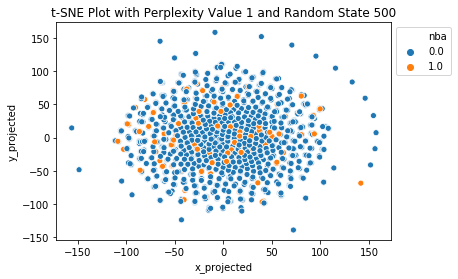

/Users/milesmathews70/opt/anaconda3/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/Users/milesmathews70/opt/anaconda3/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


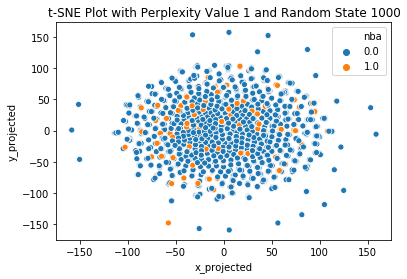

--------------------------------------------


/Users/milesmathews70/opt/anaconda3/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/Users/milesmathews70/opt/anaconda3/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


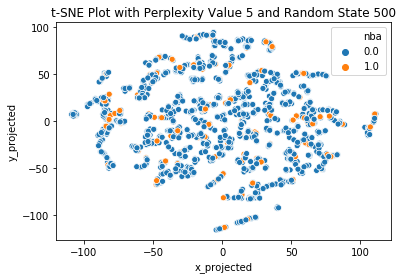

/Users/milesmathews70/opt/anaconda3/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/Users/milesmathews70/opt/anaconda3/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


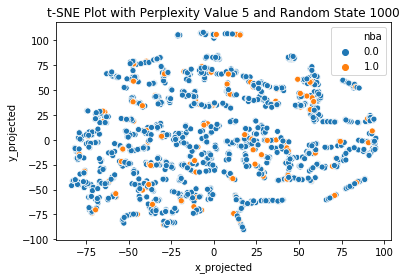

--------------------------------------------


/Users/milesmathews70/opt/anaconda3/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/Users/milesmathews70/opt/anaconda3/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


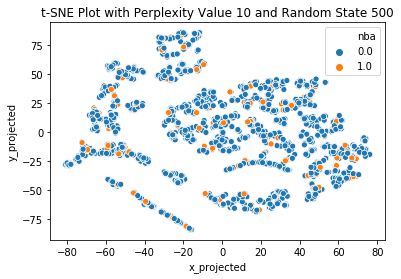

/Users/milesmathews70/opt/anaconda3/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/Users/milesmathews70/opt/anaconda3/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


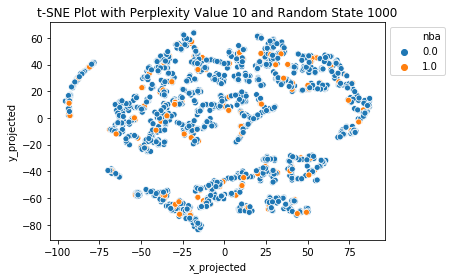

--------------------------------------------


/Users/milesmathews70/opt/anaconda3/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/Users/milesmathews70/opt/anaconda3/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


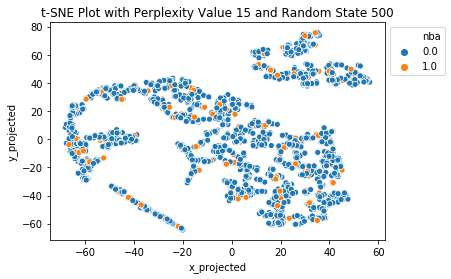

/Users/milesmathews70/opt/anaconda3/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/Users/milesmathews70/opt/anaconda3/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


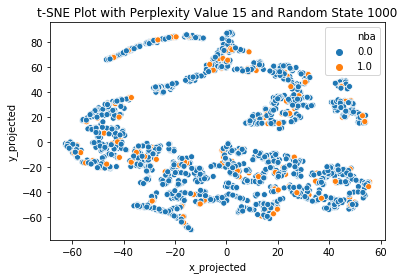

--------------------------------------------


/Users/milesmathews70/opt/anaconda3/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/Users/milesmathews70/opt/anaconda3/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


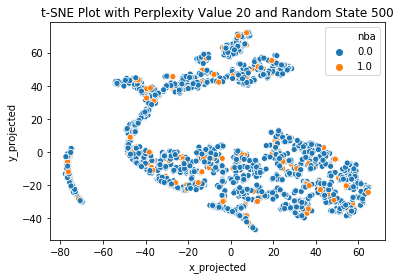

/Users/milesmathews70/opt/anaconda3/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/Users/milesmathews70/opt/anaconda3/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


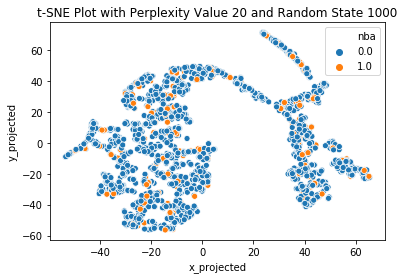

--------------------------------------------


/Users/milesmathews70/opt/anaconda3/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/Users/milesmathews70/opt/anaconda3/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


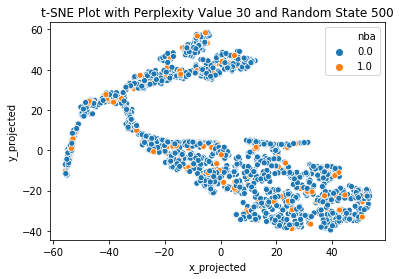

/Users/milesmathews70/opt/anaconda3/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/Users/milesmathews70/opt/anaconda3/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


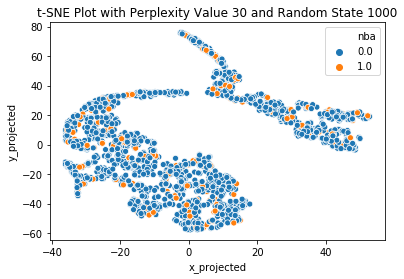

--------------------------------------------


/Users/milesmathews70/opt/anaconda3/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/Users/milesmathews70/opt/anaconda3/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


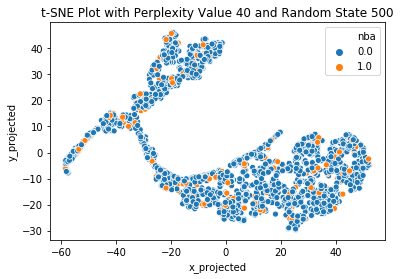

/Users/milesmathews70/opt/anaconda3/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/Users/milesmathews70/opt/anaconda3/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


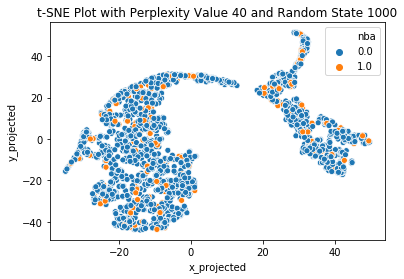

--------------------------------------------


/Users/milesmathews70/opt/anaconda3/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/Users/milesmathews70/opt/anaconda3/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


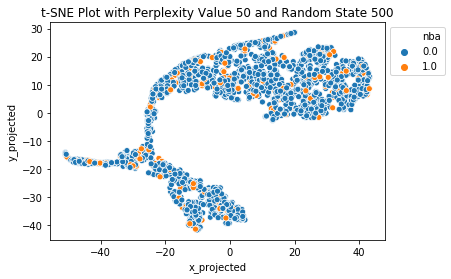

/Users/milesmathews70/opt/anaconda3/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/Users/milesmathews70/opt/anaconda3/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


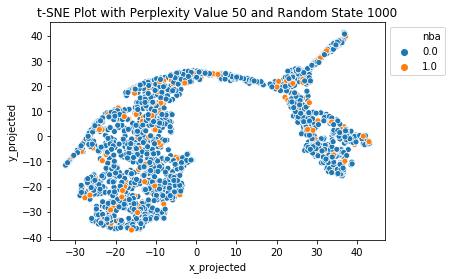

--------------------------------------------


/Users/milesmathews70/opt/anaconda3/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/Users/milesmathews70/opt/anaconda3/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


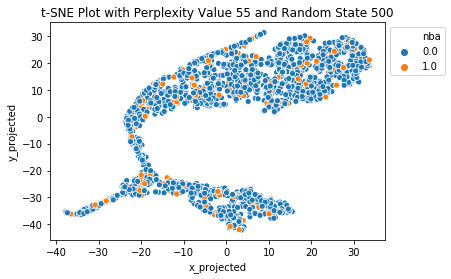

/Users/milesmathews70/opt/anaconda3/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/Users/milesmathews70/opt/anaconda3/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


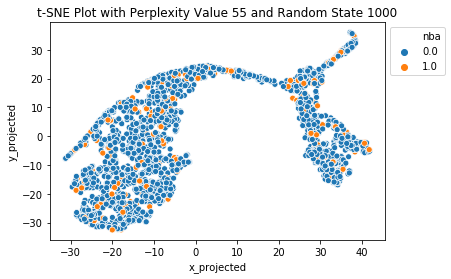

--------------------------------------------


In [369]:
for perp in [1, 5, 10, 15, 20, 30, 40, 50, 55]: 
    for rs in [500, 1000]:
        tsne = TSNE(n_components=2, perplexity=perp, random_state=rs)
        data_tsne = tsne.fit_transform(sub_df)
        df_tsne = pd.DataFrame(data_tsne, columns=['x_projected', 'y_projected'])
        df_combo = pd.concat([sub_df, df_tsne], axis=1)
        df_combo['nba'] = cbb['nba']
        sns.scatterplot(x='x_projected',y='y_projected', hue='nba', data=df_combo)
        plt.title('t-SNE Plot with Perplexity Value %s and Random State %s' %(perp, rs))
        plt.legend(bbox_to_anchor=(1,1))
        plt.show()
    print('--------------------------------------------')

k= 1
k= 2
k= 3
k= 4
k= 5
k= 6
k= 7
k= 8
k= 9
k= 10
k= 11


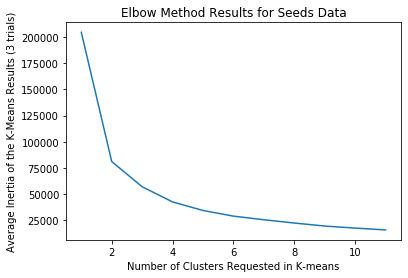

In [370]:
cluster_num_list=range(1,12)
avg_inertia_list=[]
for k in cluster_num_list:
    print('k= '+str(k))
    sub_inertia_list=[]
    for i in range(0,3):
        kmeans=KMeans(n_clusters=k).fit(X)
        sub_inertia_list.append(kmeans.inertia_)
    avg_inertia_list.append(np.average(sub_inertia_list))
    
plt.plot(cluster_num_list,avg_inertia_list)
plt.xlabel('Number of Clusters Requested in K-means')
plt.ylabel('Average Inertia of the K-Means Results (3 trials)')
plt.title('Elbow Method Results for Seeds Data')
plt.show()

In [381]:
kmeans=KMeans(n_clusters=3).fit(X)
sub_df['predicted_cluster_kmeans']=kmeans.labels_

/Users/milesmathews70/opt/anaconda3/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/Users/milesmathews70/opt/anaconda3/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


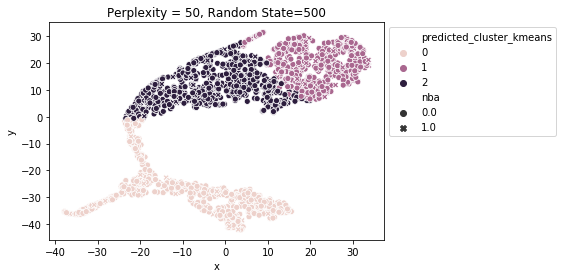

In [382]:
# Perform the TSNE non-linear dimensionality reduction
perp = 55
rs = 500

tsne = TSNE(n_components=2, perplexity=perp, random_state=rs)
data_tsne = tsne.fit_transform(X)
#concatenate the projected (x,y) coordinates (df_tsne) and the original dataset (df) into the sam
df_tsne = pd.DataFrame(data_tsne, columns=['x', 'y'], index=df.index)
dff = pd.concat([sub_df, df_tsne], axis=1)
dff['nba'] = cbb['nba']
# Plot the projected (x,y) coordinates
sns.scatterplot(x='x', y='y', hue='predicted_cluster_kmeans', style='nba', data=dff)
plt.title('Perplexity = 50, Random State=500')
plt.legend(bbox_to_anchor=(1,1))
plt.show()

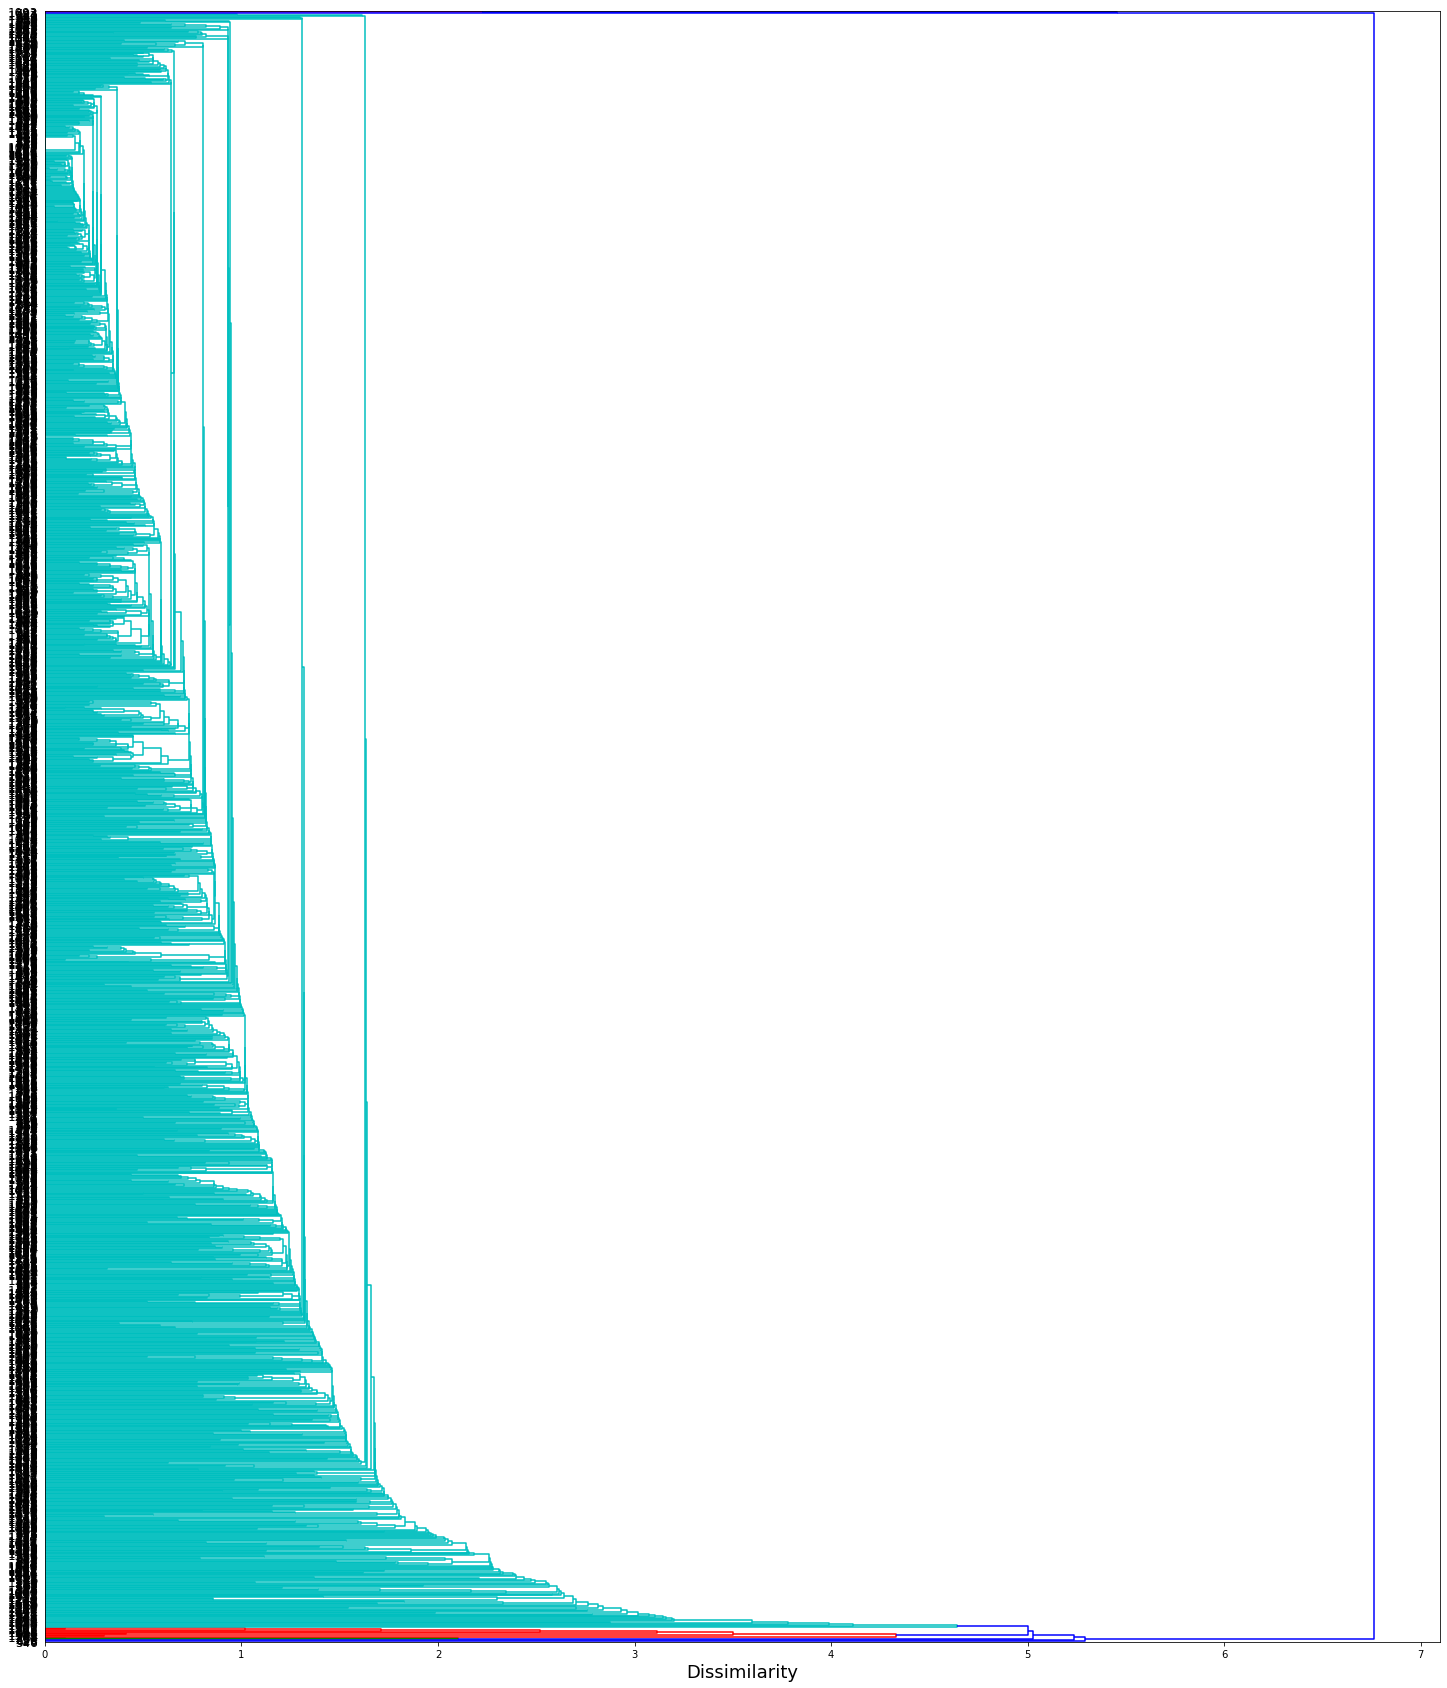

In [383]:
dm = pdist(X, metric='euclidean')
Z = linkage(dm, method='single')
fig, ax = plt.subplots(figsize=(25, 30))
d = dendrogram(Z, orientation='right', ax=ax)
ax.set_xlabel('Dissimilarity', fontsize=18)
plt.yticks(fontsize=12)
plt.show()

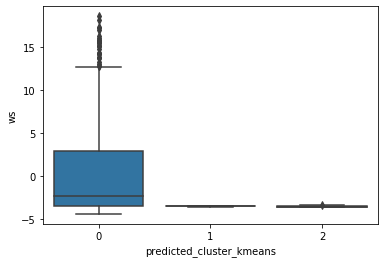

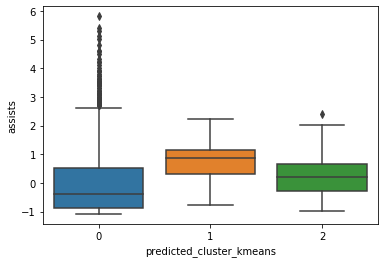

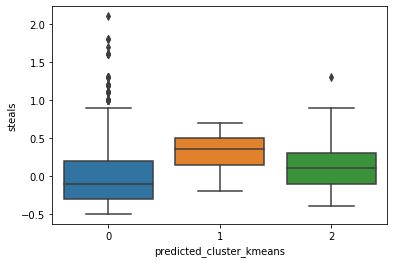

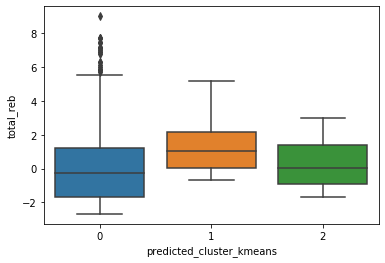

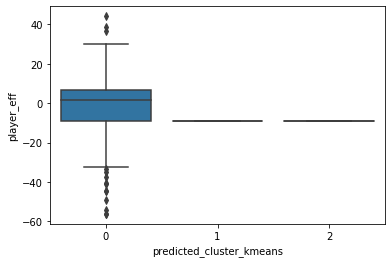

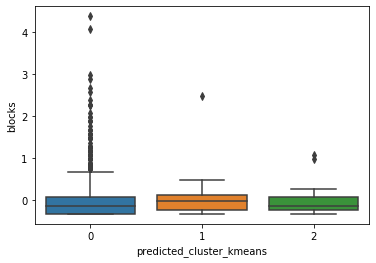

In [386]:
for col in sub_cols:
    sns.boxplot(x='predicted_cluster_kmeans', y=col, data=df)
    plt.show()